<a href="https://colab.research.google.com/github/MariaGabrielaAlvesZuppardo/SeriesTemporaisCin/blob/main/Lista_de_Exercicio_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

In [2]:
!pip install pmdarima statsmodels scikit-learn

In [3]:
#!pip install --upgrade scikit-learn pmdarima

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas import DataFrame
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

# Load Data

In [5]:
start_date = datetime(2007, 3, 18)
end_date = datetime (2025, 3, 18)
ticker = 'BTC-USD'
df =yf.download(ticker, start=start_date, end=end_date)['Close']
df = df.rename(columns={ticker:'y'})
df = df.resample('W').last()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [6]:
df

Ticker,y
Date,
2014-09-21,398.821014
2014-09-28,377.181000
2014-10-05,320.510010
2014-10-12,378.549011
2014-10-19,389.545990
...,...
2025-02-23,96273.921875
2025-03-02,94248.351562
2025-03-09,80601.039062


<Axes: xlabel='Date'>

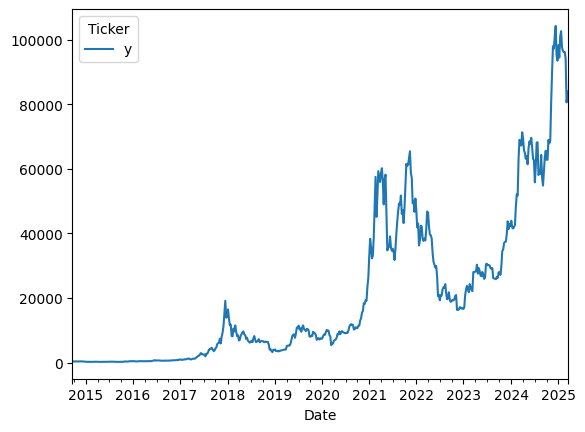

In [7]:
df.plot()

## Train / Test

In [8]:
size = int(len(df) * 0.7)
train, test = df[0:size], df[size:len(df)]
h = len(test)
print(train.shape)
print(test.shape)

(384, 1)
(165, 1)


In [9]:
train

Ticker,y
Date,
2014-09-21,398.821014
2014-09-28,377.181000
2014-10-05,320.510010
2014-10-12,378.549011
2014-10-19,389.545990
...,...
2021-12-26,50809.515625
2022-01-02,47345.218750
2022-01-09,41911.601562


# Analysis

<Axes: xlabel='Date'>

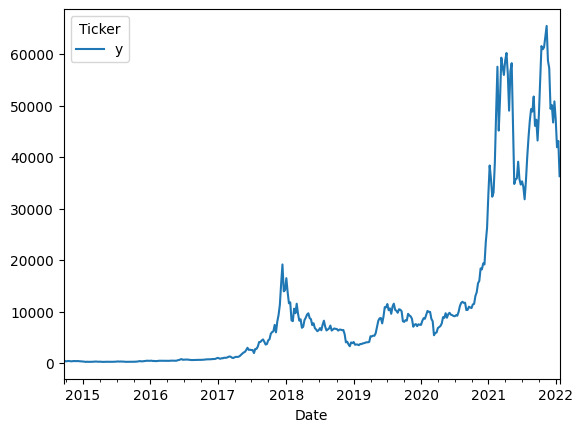

In [10]:
train.plot()

<Axes: xlabel='Date'>

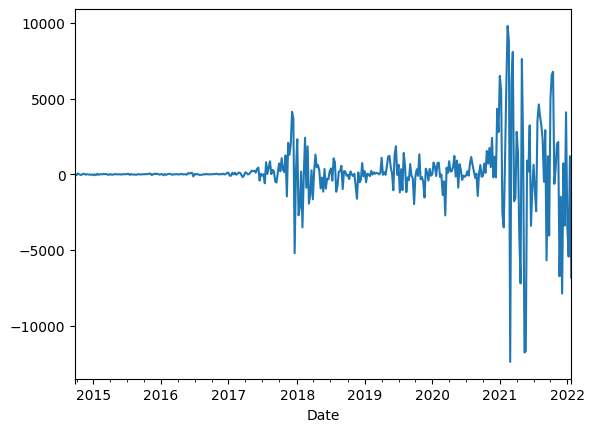

In [11]:
diff1 = train['y'].diff(1).dropna()
diff1.plot()

## Normalization

In [12]:
train_log = train.copy()
train_log['y']=np.log(train_log['y'])

In [13]:
train_log

Ticker,y
Date,
2014-09-21,5.988513
2014-09-28,5.932725
2014-10-05,5.769914
2014-10-12,5.936346
2014-10-19,5.964982
...,...
2021-12-26,10.835839
2022-01-02,10.765221
2022-01-09,10.643318


<Axes: xlabel='Date'>

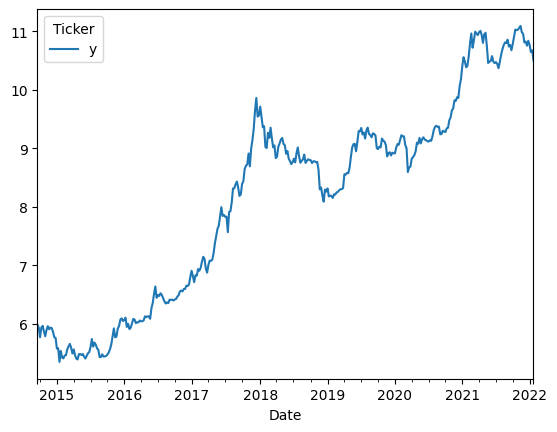

In [14]:
train_log.plot()

## Differentiation

In [15]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data

    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val

    print(out.to_string())          # .to_string() removes the line "dtype: float64"

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

### 1ª diff

In [16]:
diff1 = train_log['y'].diff(1).dropna()

<Axes: xlabel='Date'>

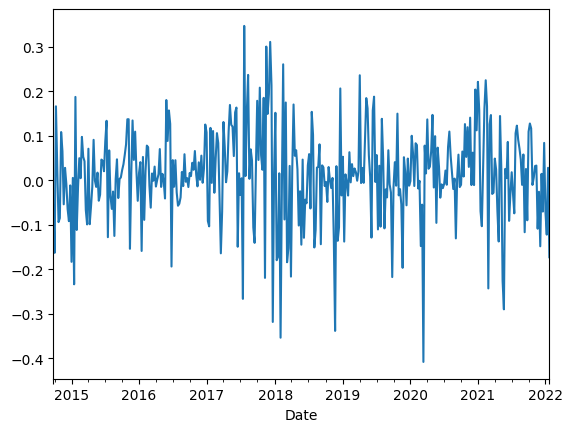

In [17]:
diff1.plot()

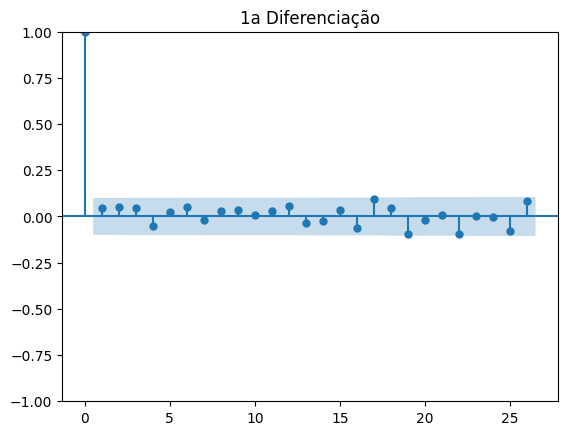

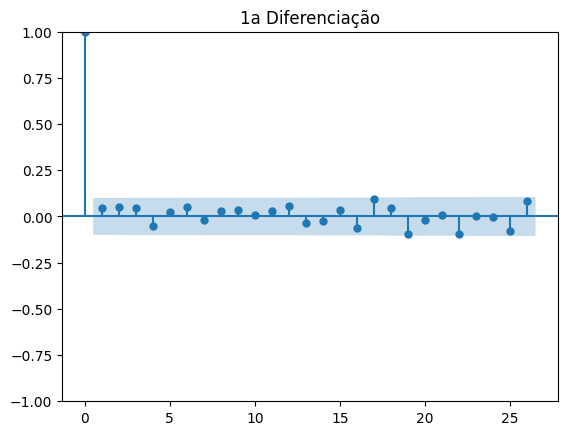

In [18]:
plot_acf(diff1, title='1a Diferenciação')

In [19]:
adf_test(diff1)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.855451e+01
p-value                 2.090662e-30
# lags used             0.000000e+00
# observations          3.820000e+02
critical value (1%)    -3.447585e+00
critical value (5%)    -2.869136e+00
critical value (10%)   -2.570816e+00
Reject the null hypothesis
Data has no unit root and is stationary


### 2ª diff

In [20]:
diff2 = diff1.diff(1).dropna()


<Axes: xlabel='Date'>

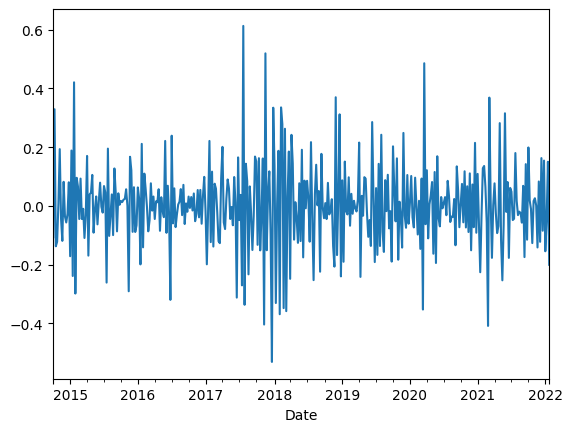

In [21]:
diff2.plot()

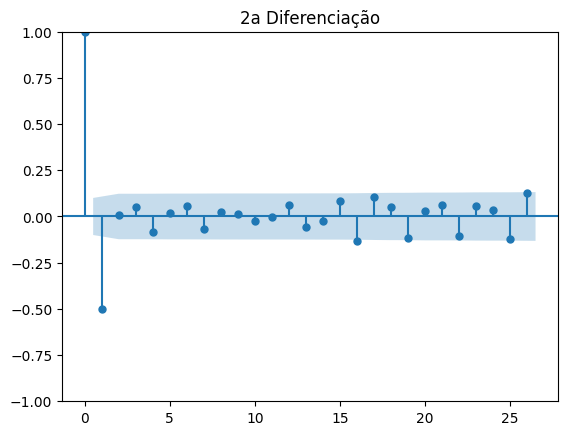

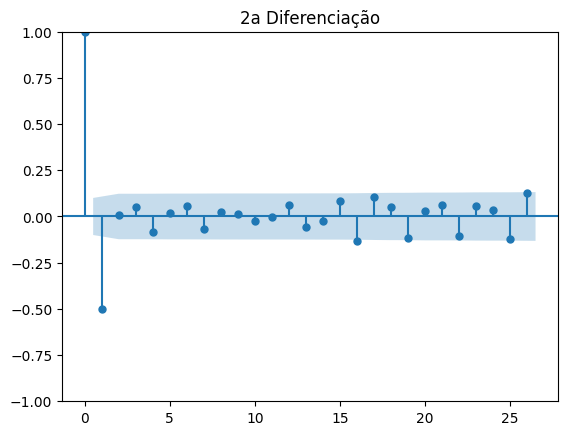

In [22]:
plot_acf(diff2, title='2a Diferenciação')

In [23]:
adf_test(diff2)

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.011821e+00
p-value                 2.191036e-12
# lags used             1.600000e+01
# observations          3.650000e+02
critical value (1%)    -3.448394e+00
critical value (5%)    -2.869491e+00
critical value (10%)   -2.571006e+00
Reject the null hypothesis
Data has no unit root and is stationary


## Conclusion
A análise dos gráficos sugere os seguintes hiperparâmetros:

In [24]:
p = 1
d = 1
q = 0

# Modelo AR

In [25]:
mod1 = AutoReg(train_log['y'], p, old_names=False)
res1 = mod1.fit()
print(res1.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  384
Model:                     AutoReg(1)   Log Likelihood                 319.227
Method:               Conditional MLE   S.D. of innovations              0.105
Date:                Wed, 26 Mar 2025   AIC                           -632.455
Time:                        22:32:37   BIC                           -620.611
Sample:                    09-28-2014   HQIC                          -627.756
                         - 01-23-2022                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0238      0.026      0.920      0.357      -0.027       0.074
y.L1           0.9985      0.003    321.829      0.000       0.992       1.005
                                    Roots           

Bons modelos são obtidos minimizando o AIC ou BIC.

<Axes: xlabel='Date'>

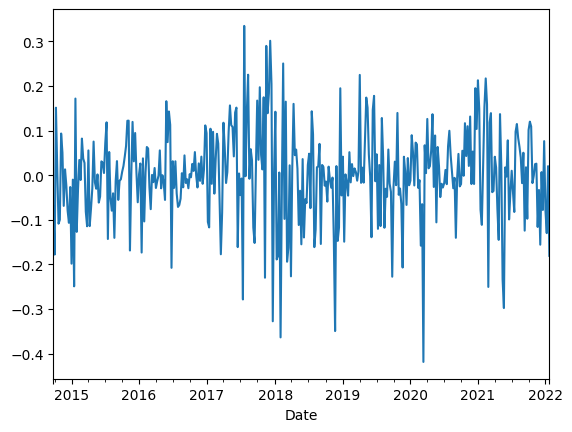

In [26]:
residuals = res1.resid
residuals.plot()

<Axes: ylabel='Density'>

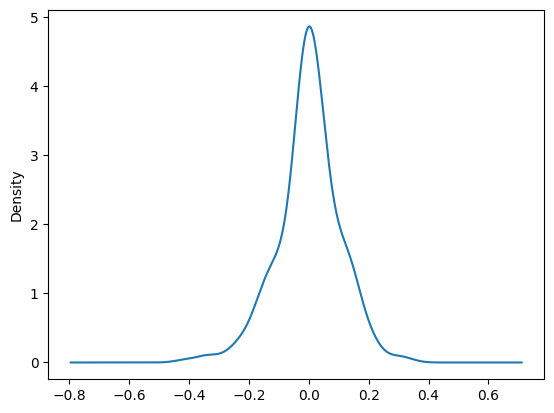

In [27]:
# density plot of residuals
residuals.plot(kind='kde')

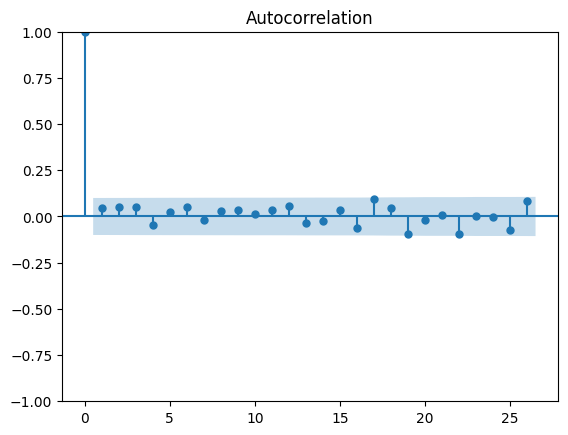

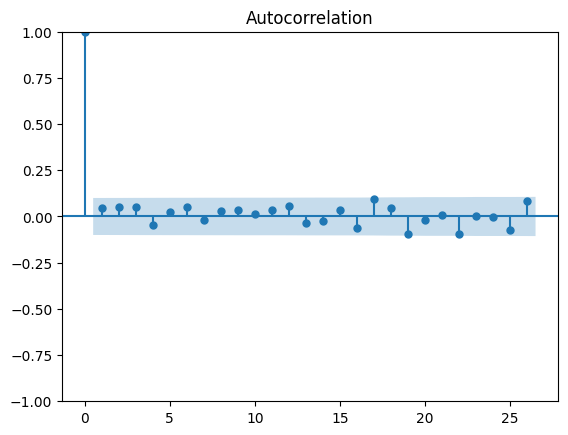

In [28]:
plot_acf(residuals)

In [29]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic     -1.854109e+01
p-value                 2.097631e-30
# lags used             0.000000e+00
# observations          3.820000e+02
critical value (1%)    -3.447585e+00
critical value (5%)    -2.869136e+00
critical value (10%)   -2.570816e+00
Reject the null hypothesis
Data has no unit root and is stationary


In [30]:
# This is the general format for obtaining predictions
start=len(train_log)
end=len(train_log)+h-1
ar_predictions = np.exp(res1.predict(start=start, end=end, dynamic=False).rename(f'AR({p}) Predictions'))

In [31]:
ar_predictions

,AR(1) Predictions
2022-01-30,36579.406982
2022-02-06,36884.082154
2022-02-13,37190.840652
2022-02-20,37499.692950
2022-02-27,37810.649550
...,...
2025-02-23,119416.717704
2025-03-02,120201.711943
2025-03-09,120990.698799
2025-03-16,121783.690933


<Axes: xlabel='Date'>

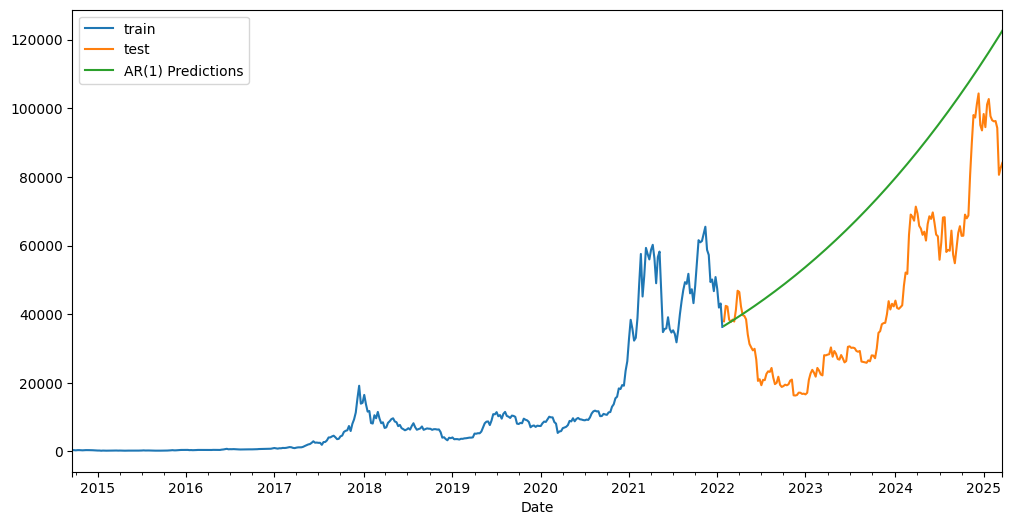

In [32]:
train['y'].plot(legend=True, label='train')
test['y'].plot(legend=True, label='test')
ar_predictions.plot(legend=True,figsize=(12,6))

In [33]:
def metrics(test, predictions):
  # Cálculo das métricas de avaliação
  mse = mean_squared_error(test['y'], predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(test['y'], predictions)
  r2 = r2_score(test['y'], predictions)

  # Calcular MAPE (Mean Absolute Percentage Error)
  mape = np.mean(np.abs((test['y'] - predictions) / test['y'])) * 100

  # Calcular SMAPE (Symmetric Mean Absolute Percentage Error)
  smape = np.mean(2 * np.abs(test['y'] - predictions) /
                (np.abs(test['y']) + np.abs(predictions))) * 100

  # Exibir as métricas
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAE: {mae}")
  print(f"R²: {r2}")
  print(f"MAPE: {mape}")
  print(f"SMAPE: {smape}")

metrics( test, ar_predictions)


MSE: 948821653.0416833
RMSE: 30802.948771857595
MAE: 28424.399906240127
R²: -0.5789191264804574
MAPE: 87.344271602036
SMAPE: 54.9581353890936


# Modelo Arima

In [34]:
arima_model = ARIMA(train_log, order=(p,d,q))
fitted_arima_model = arima_model.fit()

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 317.376
Date:                Wed, 26 Mar 2025   AIC                           -630.752
Time:                        22:32:40   BIC                           -622.856
Sample:                    09-21-2014   HQIC                          -627.620
                         - 01-23-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0584      0.042      1.393      0.164      -0.024       0.140
sigma2         0.0112      0.001     17.413      0.000       0.010       0.012
Ljung-Box (L1) (Q):                   0.09   Jarque-

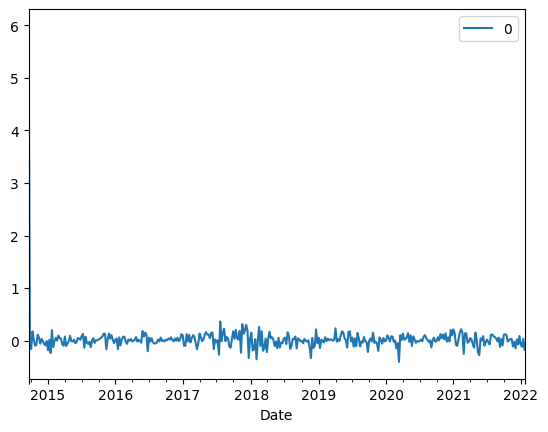

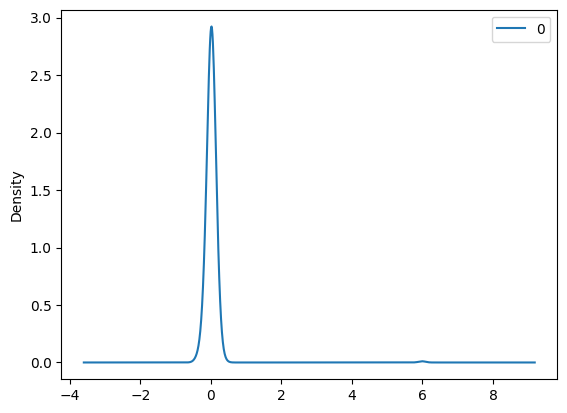

In [35]:

# summary of fit model
print(fitted_arima_model.summary())
# line plot of residuals
residuals = DataFrame(fitted_arima_model.resid)
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

# summary stats of residuals
print(residuals.describe())

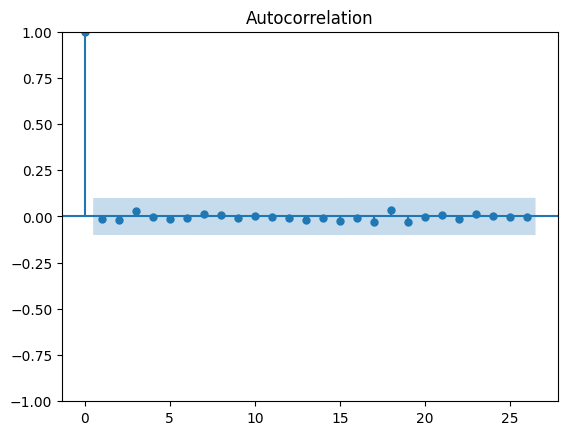

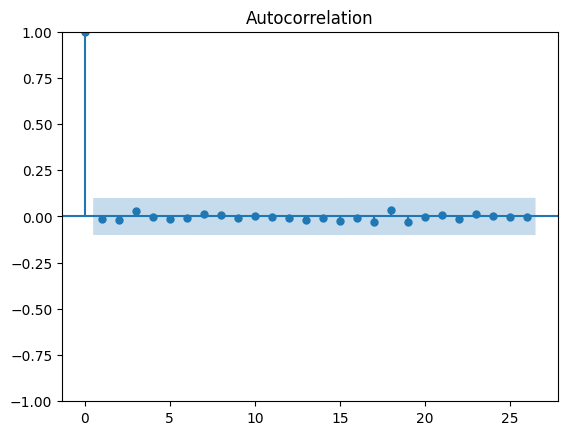

In [36]:
plot_acf(residuals)

In [37]:
adf_test(residuals)

Augmented Dickey-Fuller Test: 
ADF test statistic      -60.641751
p-value                   0.000000
# lags used               0.000000
# observations          383.000000
critical value (1%)      -3.447540
critical value (5%)      -2.869116
critical value (10%)     -2.570806
Reject the null hypothesis
Data has no unit root and is stationary


In [38]:
history = train_log['y'].tolist()

arima_predictions = np.array([])
#walk-foward validation
#test_values = test['y'].tolist()
for t in range(h):
  arima_model = ARIMA(history, order=(p,d,q))
  # fit model
  fitted_arima_model = arima_model.fit()
  yhat = np.exp(fitted_arima_model.forecast()[0])
  arima_predictions = np.append(arima_predictions, yhat)
  obs = test['y'].iloc[t]
  history.append(np.log(obs))
  print(f'predicted={yhat}, expected={obs}')



predicted=35913.11861850684, expected=37917.6015625
predicted=38011.93344662511, expected=42412.43359375
predicted=42685.547792656056, expected=42197.515625
predicted=42185.29850290515, expected=38431.37890625
predicted=38226.74448303665, expected=37709.78515625
predicted=37668.776768129035, expected=38419.984375
predicted=38461.09360306177, expected=37849.6640625
predicted=37817.27207718986, expected=41247.82421875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=41450.27047736739, expected=46820.4921875
predicted=47174.07709842989, expected=46453.56640625
predicted=46432.03685539691, expected=42207.671875
predicted=41969.275216530936, expected=39716.953125
predicted=39571.526868147426, expected=39469.29296875
predicted=39454.39714093573, expected=38469.09375
predicted=38409.517176461006, expected=34059.265625
predicted=33806.86958333564, expected=31305.11328125
predicted=31138.636351824152, expected=30323.72265625


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=30262.215435486214, expected=29445.95703125
predicted=29390.6995696337, expected=29906.662109375
predicted=29936.312119533057, expected=26762.6484375
predicted=26574.752016833216, expected=20553.271484375
predicted=20177.291998449327, expected=21027.294921875
predicted=21059.678963638904, expected=19297.076171875
predicted=19186.301395130427, expected=20860.44921875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=20967.058864926923, expected=20779.34375
predicted=20774.060176459418, expected=22609.1640625
predicted=22733.928130684213, expected=23336.896484375
predicted=23385.520006271563, expected=23175.890625
predicted=23165.36181963065, expected=24319.333984375
predicted=24396.239778052386, expected=21534.12109375
predicted=21366.56853303754, expected=19616.814453125
predicted=19495.48629384799, expected=19986.712890625
predicted=20011.376025754595, expected=21769.255859375
predicted=21893.02977054157, expected=19419.505859375
predicted=19277.854777987806, expected=18802.09765625
predicted=18762.81854505965, expected=19044.107421875
predicted=19059.852739743103, expected=19446.42578125
predicted=19472.737009750683, expected=19268.09375
predicted=19256.62499274666, expected=19567.0078125
predicted=19586.474876401702, expected=20635.603515625
predicted=20706.79820229159, expected=20926.486328125
predicted=20945.504633809975, expected=16353.365234375


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=16096.79147269712, expected=16291.83203125
predicted=16287.933422990714, expected=16444.626953125
predicted=16454.374161500324, expected=17130.486328125
predicted=17175.033353309213, expected=17104.193359375
predicted=17102.52453554322, expected=16757.9765625
predicted=16736.220005408948, expected=16841.986328125
predicted=16847.33522861953, expected=16625.080078125
predicted=16611.40414085447, expected=17091.14453125
predicted=17121.132583100607, expected=20880.798828125
predicted=21152.700498599017, expected=22720.416015625
predicted=22850.64257290477, expected=23774.56640625
predicted=23848.444127193885, expected=22955.666015625
predicted=22900.98532857602, expected=21788.203125
predicted=21710.537087480323, expected=24327.642578125
predicted=24508.369106455855, expected=23561.212890625
predicted=23511.3330319491, expected=22435.513671875
predicted=22362.56306540758, expected=22163.94921875
predicted=22145.975069402513, expected=28038.67578125
predicted=28477.18712189602, 

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=62639.57972485556, expected=62851.375
predicted=62853.48854531315, expected=69001.703125
predicted=69422.86883030925, expected=67929.296875


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


predicted=67860.40648368376, expected=68741.1171875
predicted=68794.0056389164, expected=80474.1875
predicted=81304.11733120546, expected=89845.8515625
predicted=90523.54105964644, expected=98013.8203125
predicted=98612.11866532417, expected=97279.7890625
predicted=97228.82738849548, expected=101236.015625
predicted=101517.47503467354, expected=104298.6953125
predicted=104516.08173577486, expected=95104.9375
predicted=94498.63983537896, expected=93530.2265625
predicted=93421.76936207626, expected=98314.9609375
predicted=98655.59770728585, expected=94488.4375
predicted=94230.32935005146, expected=101089.609375
predicted=101557.32804518948, expected=102682.5
predicted=102792.53061158715, expected=97688.9765625
predicted=97356.69078599542, expected=96500.09375
predicted=96419.26647161371, expected=96175.03125
predicted=96152.82450651504, expected=96273.921875
predicted=96280.69344506173, expected=94248.3515625
predicted=94111.30304990584, expected=80601.0390625
predicted=79734.80224337593

<Axes: xlabel='ds'>

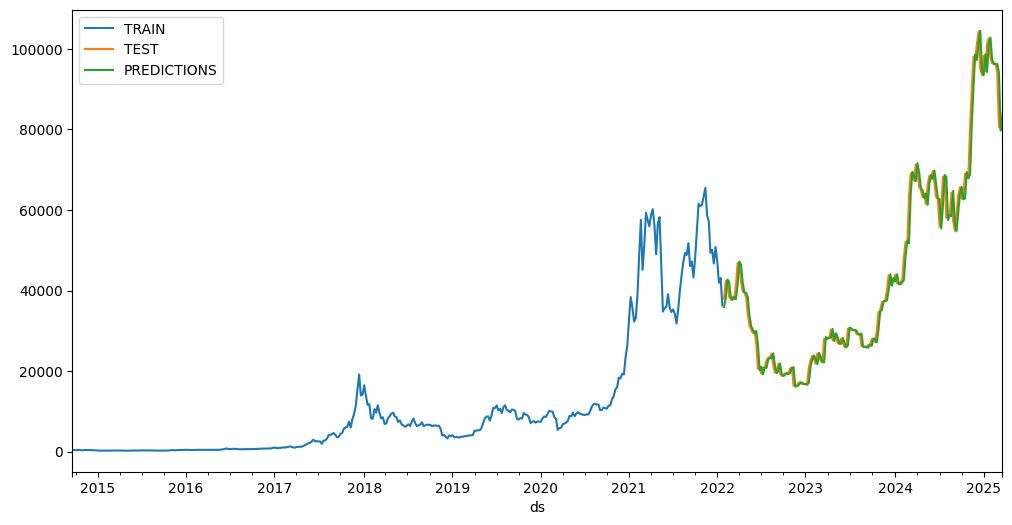

In [39]:
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':arima_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


In [40]:
metrics(test, arima_predictions)

MSE: 11103045.416729376
RMSE: 3332.123259534283
MAE: 2221.5580586218266
R²: 0.9815235974912083
MAPE: 5.044868784877645
SMAPE: 5.046804793768751


In [42]:
fitted_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  548
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 501.980
Date:                Wed, 26 Mar 2025   AIC                           -999.960
Time:                        22:33:32   BIC                           -991.351
Sample:                             0   HQIC                          -996.595
                                - 548                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0680      0.034      1.991      0.046       0.001       0.135
sigma2         0.0093      0.000     22.231      0.000       0.009       0.010
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                86.72
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Modelo Exponential Smoothing

/usr/local/lib/python3.11/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='ds'>

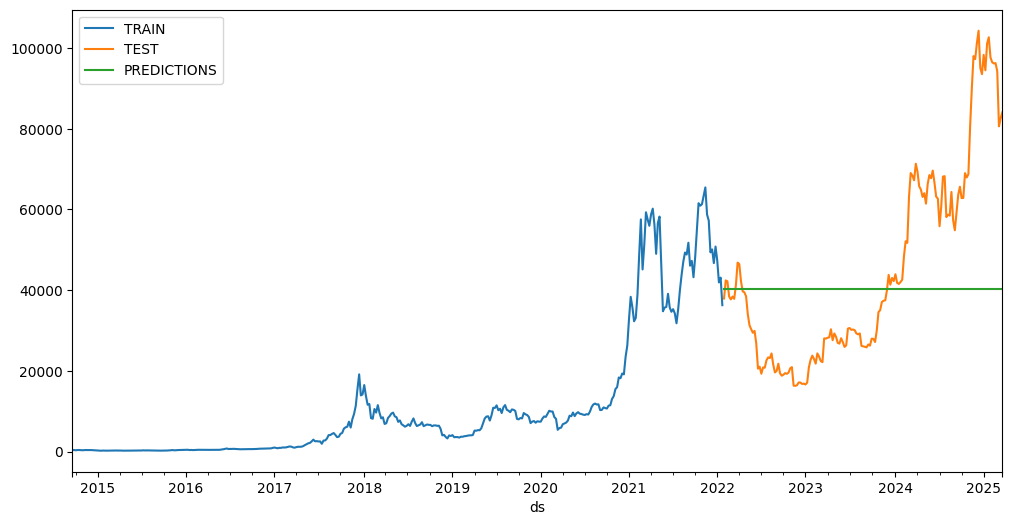

In [43]:
# Simple Exponential Smoothing (SES) for data without trends or seasonality
ses_model = SimpleExpSmoothing(train)
fitted_ses_model = ses_model.fit(smoothing_level=0.5)
ses_predictions = fitted_ses_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':ses_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Holt

<Axes: xlabel='ds'>

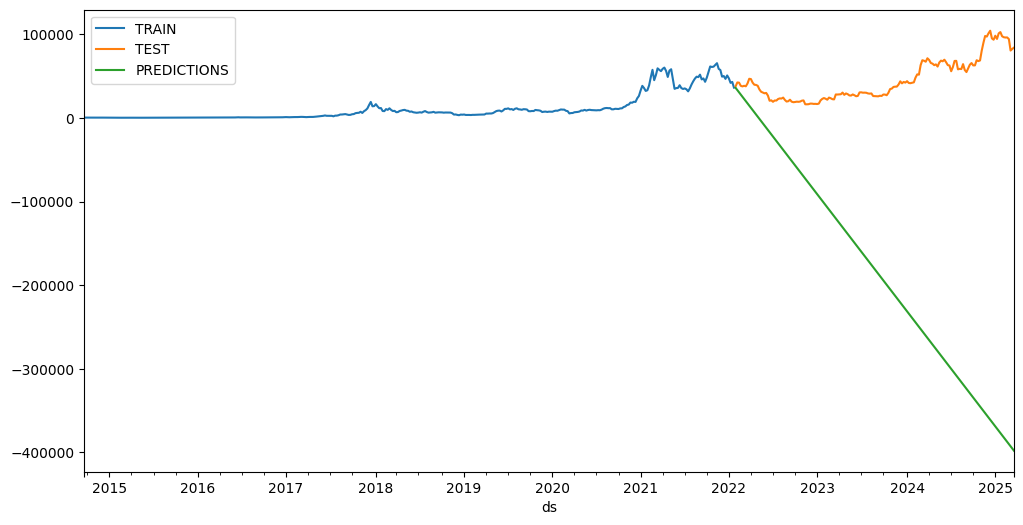

In [44]:
# Double exponential smoothing, also known as Holt's method, extends single exponential smoothing to capture trends in the data.

holt_model = ExponentialSmoothing(train, trend="add", seasonal=None)
fitted_holt_model = holt_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
holt_predictions = fitted_holt_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':holt_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))


# Modelo Damped

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<Axes: xlabel='ds'>

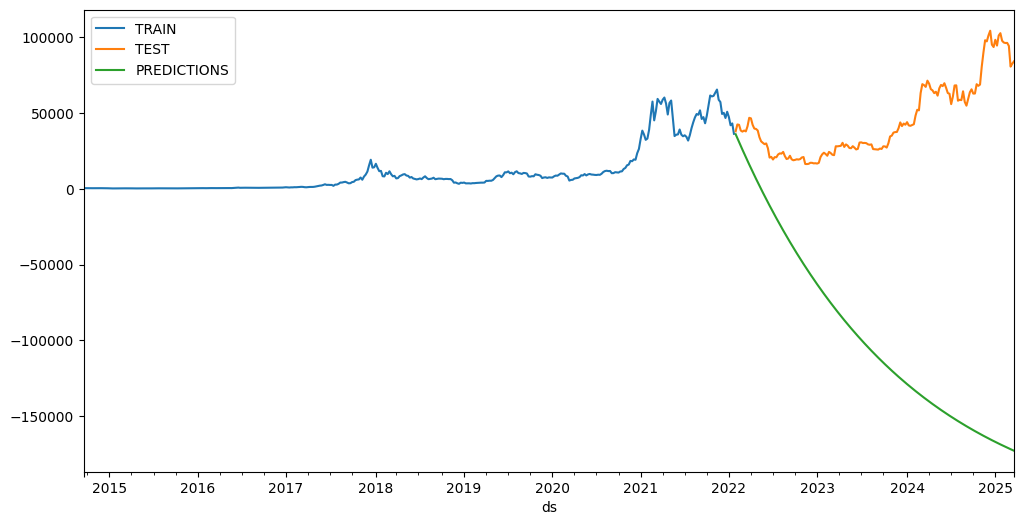

In [45]:
# The Damped Trend model is an extension of Holt’s linear method that introduces a damping parameter (ϕ),
# which gradually reduces the influence of the trend component over time

damped_model = ExponentialSmoothing(train, trend="add", seasonal=None, damped_trend=True)
fitted_damped_model = damped_model.fit(smoothing_level=0.5, smoothing_trend=0.5)
damped_predictions = fitted_damped_model.forecast(h)
train['y'].plot(legend=True, label='TRAIN')
test['y'].plot(legend=True, label='TEST')
pd.DataFrame({'ds':test.index, 'y':damped_predictions}).set_index('ds')['y'].plot(legend=True, label='PREDICTIONS', figsize=(12, 6))
